In [1]:
import scanpy as sc
import numpy as np
import pandas as pd
from glob import glob
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from scipy.cluster.hierarchy import linkage, leaves_list
from sklearn.preprocessing import MinMaxScaler
import sklearn.metrics as metrics

In [4]:
import os
import sys
module_path = os.path.abspath('/mnt/c/Users/demeter_turos/PycharmProjects/chrysalis')
if module_path not in sys.path:
    sys.path.append(module_path)

import chrysalis as ch

data_path = '/mnt/c/Users/demeter_turos/PycharmProjects/chrysalis/data/xenium_human_breast_cancer/'
morphology_path = '/mnt/c/Users/demeter_turos/PycharmProjects/chrysalis/dev/morphology/jelica'

plt.rcParams['svg.fonttype'] = 'none'

In [5]:
# read file and do PCA


def array_scale(arr):
    mean = np.mean(arr)
    std = np.std(arr)
    scaled_arr = (arr - mean) / std
    return scaled_arr


adata = sc.read_h5ad(data_path + 'visium_sample_annotated.h5ad')

sc.pp.normalize_total(adata, inplace=True)
sc.pp.log1p(adata)

ch.pca(adata, n_pcs=50)

ch.aa(adata, n_pcs=20, n_archetypes=8)

di = {'B_Cells': 'B cell', 'CD4+_T_Cells': 'CD4+ T cell', 'CD8+_T_Cells': 'CD8+ T cell', 'DCIS_1': 'DCIS #1',
      'DCIS_2': 'DCIS #2',
       'Endothelial': 'Endothelial cell', 'IRF7+_DCs': 'IRF7+ Dendritic cell', 'Invasive_Tumor': 'Invasive tumor',
      'LAMP3+_DCs': 'LAMP3+ Dendritic cell',
       'Macrophages_1': 'Macrophage #1', 'Macrophages_2': 'Macrophage #2', 'Mast_Cells': 'Mast cell',
      'Myoepi_ACTA2+': 'ACTA2+ Myoepithelial cell',
       'Myoepi_KRT15+': 'KRT15+ Myoepithelial cell', 'Perivascular-Like': 'Perivascular-like',
      'Prolif_Invasive_Tumor': 'Proliferative inv. tumor',
       'Stromal': 'Stromal cell', 'Stromal_&_T_Cell_Hybrid': 'Stromal & T cell',
      'T_Cell_&_Tumor_Hybrid': 'T cell & tumor',
       'Unlabeled': 'Unlabeled'}

cell_type_df = pd.read_csv(data_path + 'cell_type_abundance.csv', index_col=0)
cell_type_df = cell_type_df.rename(columns=di)

adata.obs[cell_type_df.columns] = cell_type_df
cell_type_df = adata.obs[cell_type_df.columns]

adata_bkp = adata.copy()

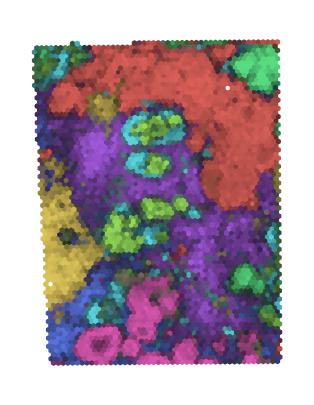

In [7]:
mfeatures = glob(morphology_path + '/*autoencoder*.npy')
data_path = '/mnt/c/Users/demeter_turos/PycharmProjects/chrysalis/data/xenium_human_breast_cancer/'
output_vec = np.load(data_path + "aenc_features_512_v2.npy")[:, :]
spot_df = pd.read_csv(data_path + "tiles_299_data.csv", index_col=0)

adata = adata_bkp.copy()

# spots under tissue
spot_df = spot_df[spot_df['1'] == 1]
adata = adata[adata.obs.index.isin(spot_df.index)]

# reorder vectors
output_vec_df = pd.DataFrame(data=output_vec, index=spot_df.index)
output_vec_df = output_vec_df.loc[[x for x in output_vec_df.index if x in (adata.obs.index)]]
output_vec_df = output_vec_df.loc[adata.obs_names]

mf_name = 'aenc_features_512'

pca = PCA(n_components=15, svd_solver='arpack', random_state=42)
adata.obsm['chr_X_pca_morphology'] = pca.fit_transform(output_vec_df)

scaler = MinMaxScaler()
ss_expression_pcs = scaler.fit_transform(adata.obsm['chr_X_pca'])
ss_morphology_pcs = scaler.fit_transform(adata.obsm['chr_X_pca_morphology'])

i = 10
adata.obsm['chr_X_pca'][:, :20] = ss_expression_pcs[:, :20]
adata.obsm['chr_X_pca'][:, 20:20 + i] = ss_morphology_pcs[:, 0:i]

ch.aa(adata, n_pcs=20 + i, n_archetypes=8)

compartment_df = pd.DataFrame(data=adata.obsm['chr_aa'],
                              index=adata.obs_names,
                              columns=range(adata.obsm['chr_aa'].shape[1]))

ch.plot(adata, dim=8, seed=30, spot_size=0.95)
plt.show()

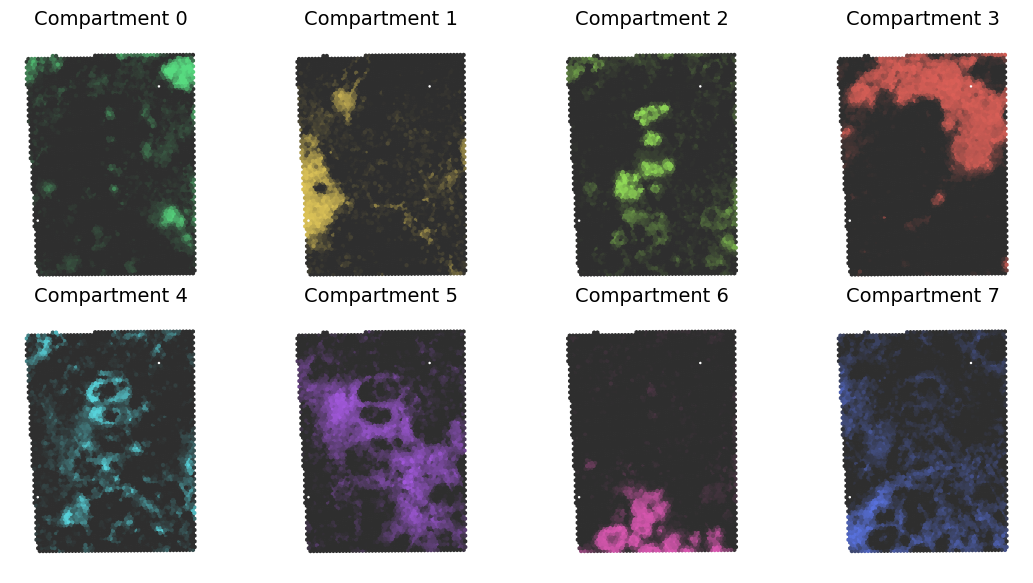

In [8]:
ch.plot_compartments(adata, ncols=4, seed=30, title_size=14, rasterized=True, spot_size=0.95)
plt.show()

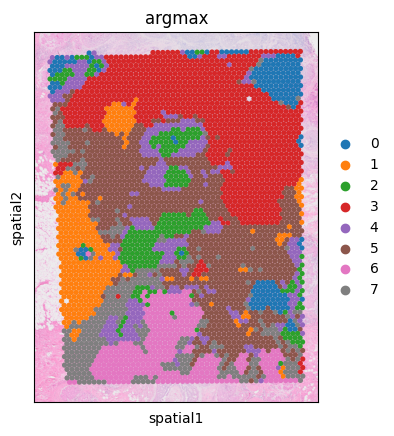

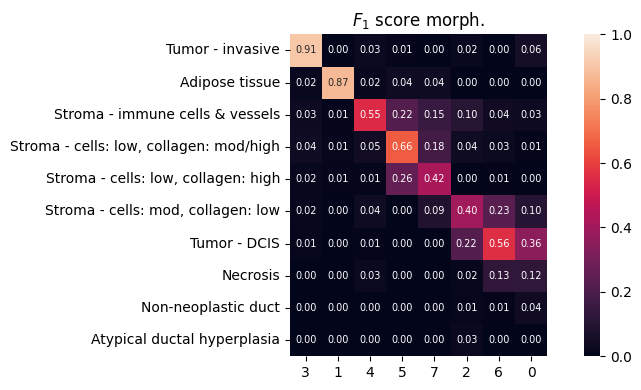

In [9]:
tissue_comps = adata.obsm['chr_aa']
adata.obs['argmax'] = np.argmax(tissue_comps, axis=1)
adata.obs['argmax'] = adata.obs['argmax'].astype('category')
sc.pl.spatial(adata, color=['argmax'], s=9)

f1 = {}
for idx, annot in enumerate(np.unique(adata.obs['annotations'])):
    selected_annot = adata.obs['annotations'] == annot
    annot_l = []
    for i in range(8):
        binary_predictions = adata.obs['argmax'] == i
        f1_score = metrics.f1_score(selected_annot, binary_predictions)
        annot_l.append(f1_score)
    f1[annot] = annot_l

colnames = {'tumor3_invasive&stroma': 'Tumor - invasive', 'Adipose tissue': 'Adipose tissue',
            'stroma3_cell low_collagen mod/high': 'Stroma - cells: low, collagen: mod/high',
            'stroma1_immune cell&vessel enriched': 'Stroma - immune cells & vessels',
            'stroma4_cell low_collagen high': 'Stroma - cells: low, collagen: high',
            'tumor1&2_DCIS': 'Tumor - DCIS', 'stroma2_mod cell_collagen low': 'Stroma - cells: mod, collagen: low',
            'Necrosis': 'Necrosis',
            'atypical ductal hyperplasia': 'Atypical ductal hyperplasia', 'Duct_non neoplastic': 'Non-neoplastic duct',
            'NA': 'NA'}

# corr matrix
f1_df = pd.DataFrame(f1).T
f1_df = f1_df.rename(index=colnames)
f1_df = f1_df.drop(index=['NA'])

rorder = [9, 0, 4, 6, 7, 5, 8, 2, 1, 3, ]
f1_df = f1_df.iloc[rorder, :]
corder = [3, 1, 4, 5, 7, 2, 6, 0]
f1_df = f1_df.iloc[:, corder]

fig, ax = plt.subplots(1, 1, figsize=(8, 4))
sns.heatmap(f1_df, ax=ax, cmap='rocket',
            square=True, rasterized=True, center=0.5, vmin=0, vmax=1,
            annot_kws = {'fontsize': 7},  fmt=".2f", annot=True)
plt.title("$F_{1}$ score morph.")
plt.tight_layout()
plt.show()

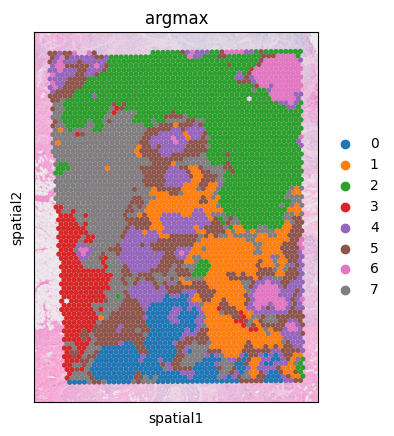

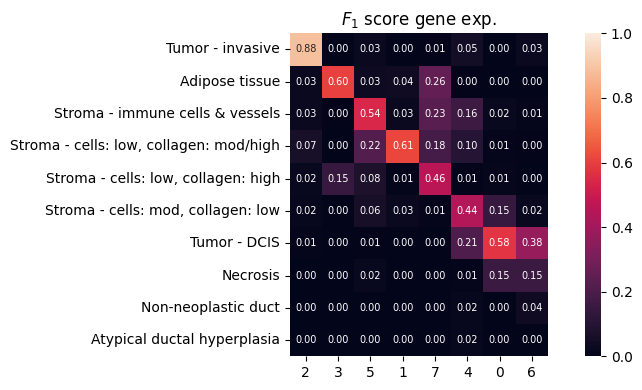

In [10]:
tissue_comps = adata_bkp.obsm['chr_aa']
adata_bkp.obs['argmax'] = np.argmax(tissue_comps, axis=1)
adata_bkp.obs['argmax'] = adata_bkp.obs['argmax'].astype('category')
sc.pl.spatial(adata_bkp, color=['argmax'], s=9)

f1 = {}
for idx, annot in enumerate(np.unique(adata_bkp.obs['annotations'])):
    selected_annot = adata_bkp.obs['annotations'] == annot
    annot_l = []
    for i in range(8):
        binary_predictions = adata_bkp.obs['argmax'] == i
        f1_score = metrics.f1_score(selected_annot, binary_predictions)
        annot_l.append(f1_score)
    f1[annot] = annot_l

colnames = {'tumor3_invasive&stroma': 'Tumor - invasive', 'Adipose tissue': 'Adipose tissue',
            'stroma3_cell low_collagen mod/high': 'Stroma - cells: low, collagen: mod/high',
            'stroma1_immune cell&vessel enriched': 'Stroma - immune cells & vessels',
            'stroma4_cell low_collagen high': 'Stroma - cells: low, collagen: high',
            'tumor1&2_DCIS': 'Tumor - DCIS', 'stroma2_mod cell_collagen low': 'Stroma - cells: mod, collagen: low',
            'Necrosis': 'Necrosis',
            'atypical ductal hyperplasia': 'Atypical ductal hyperplasia', 'Duct_non neoplastic': 'Non-neoplastic duct',
            'NA': 'NA'}

# corr matrix
f1_df = pd.DataFrame(f1).T
f1_df = f1_df.rename(index=colnames)
f1_df = f1_df.drop(index=['NA'])

rorder = [9, 0, 4, 6, 7, 5, 8, 2, 1, 3, ]
f1_df = f1_df.iloc[rorder, :]

corder = [2, 3, 5, 1, 7, 4, 0, 6]
f1_df = f1_df.iloc[:, corder]

fig, ax = plt.subplots(1, 1, figsize=(8, 4))
sns.heatmap(f1_df, ax=ax, cmap='rocket',
            square=True, rasterized=True, center=0.5, vmin=0, vmax=1,
            annot_kws = {'fontsize': 7},  fmt=".2f", annot=True)
plt.title("$F_{1}$ score gene exp.")
plt.tight_layout()
plt.show() 

In [11]:
arig = metrics.adjusted_rand_score(adata_bkp.obs['argmax'], adata_bkp.obs['annotations'])
arim = metrics.adjusted_rand_score(adata.obs['argmax'], adata.obs['annotations'])
print(f'Gene expression: {arig:.3f}')
print(f'Morphology integrated: {arim:.3f}')

Gene expression: 0.431
Morphology integrated: 0.501
